In [69]:
import numpy as np
import torch
import torch.nn as nn

x = nn.Linear(3, 3)
print(x)
print(x.weight)
print(x.bias)

Linear(in_features=3, out_features=3, bias=True)
Parameter containing:
tensor([[ 0.3067,  0.1942, -0.1861],
        [-0.4418, -0.4339, -0.1888],
        [ 0.0953, -0.4684, -0.0619]], requires_grad=True)
Parameter containing:
tensor([ 0.4389,  0.5619, -0.3333], requires_grad=True)


In [70]:
# generate x, A, y. y = A*x + b
A = np.array([[3, 4], [-2, 2]])
print('A =\n', A)

x = np.random.randint(-10, 10, size = [2, 10])
y = np.matmul(A, x)
print('x =\n', x)
print('y =\n', y)

A =
 [[ 3  4]
 [-2  2]]
x =
 [[-6 -4  5  7  1  1  3 -8 -2 -1]
 [ 9 -6 -9  1  8 -8  1  6 -9  4]]
y =
 [[ 18 -36 -21  25  35 -29  13   0 -42  13]
 [ 30  -4 -28 -12  14 -18  -4  28 -14  10]]


In [71]:
class Fit(nn.Module):
    def __init__(self):
        super(Fit, self).__init__()
        self.w = nn.Linear(2, 2)

    # xb is a bacth of x_i, i.e., x1, x2, .., xn
    def forward(self, xb):
        bsz = xb.shape[0]
        yb = self.w(xb) 
        # torch.matmul(self.w, xb) 
        return yb

xb = torch.tensor(x.transpose().astype('float32'))
yb = torch.tensor(y.transpose().astype('float32'))
f = Fit()
yf = f(xb)
print('xb=', xb)
print('yf=', yf)

xb= tensor([[-6.,  9.],
        [-4., -6.],
        [ 5., -9.],
        [ 7.,  1.],
        [ 1.,  8.],
        [ 1., -8.],
        [ 3.,  1.],
        [-8.,  6.],
        [-2., -9.],
        [-1.,  4.]])
yf= tensor([[ 5.9178, -0.2766],
        [-1.4562, -1.6872],
        [-5.2825,  0.3871],
        [-1.2778,  2.2408],
        [ 3.5487,  1.5108],
        [-3.7336, -0.5783],
        [-0.1842,  1.1448],
        [ 5.0992, -1.2164],
        [-3.3685, -1.5309],
        [ 2.2750,  0.4405]], grad_fn=<AddmmBackward0>)


In [77]:
# Create the network (from previous section) and optimizer
f = Fit()
optimizer = torch.optim.SGD(f.parameters(), lr = 1e-4, 
                            weight_decay = 1e-2, momentum = 0.9)

# Run a sample training loop that "teaches" the network
# to minimize the L1 loss
for _ in range(2000):
  input = xb
  output = f(input)
  loss = nn.functional.l1_loss(output, yb)
  f.zero_grad()
  loss.backward()
  optimizer.step()

# After training, switch the module to eval mode to do inference, compute performance metrics, etc.
# (see discussion below for a description of training and evaluation modes)
...
f.eval()
print(f.w.weight, f.w.bias)

Parameter containing:
tensor([[ 1.9489,  3.3709],
        [-1.9997,  1.9997]], requires_grad=True) Parameter containing:
tensor([-4.0589e-01,  4.9759e-05], requires_grad=True)


Sin()
Parameter containing:
tensor([0.7858], requires_grad=True) vs. 0.78539815


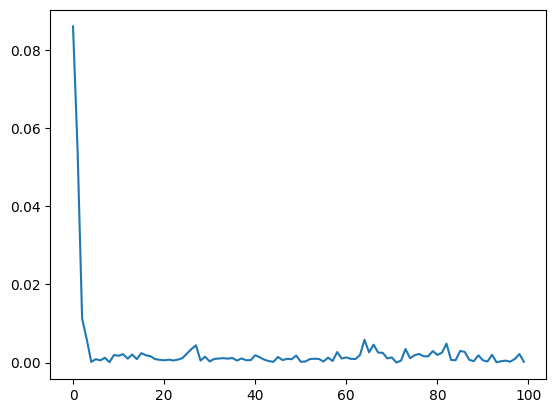

In [129]:
import matplotlib.pyplot as plt

# create a customized module
class Sin(nn.Module):
    def __init__(self):
        super(Sin, self).__init__()
        # -- must register this as parameter
        self.w = torch.nn.Parameter(torch.rand(1))

    # xb is a bacth of x_i, i.e., x1, x2, .., xn
    # y = sin(k1*x0 + k2*x1)
    def forward(self, input):
        output = torch.sin(input * self.w)
        # output.requires_grad=True
        return output

sn = Sin()
print(sn)

k = 3.1415926 / 4

def gen_samples():
    x = np.random.uniform(-10, 10, [20, 2])
    y = np.sin(k * x)
    xb = torch.tensor(x.transpose().astype('float32'))
    yb = torch.tensor(y.transpose().astype('float32'))
    return xb, yb

optimizer = torch.optim.SGD(sn.parameters(), lr = 1e-4, 
                            weight_decay = 1e-2, momentum = 0.9)

ep = []
xb, yb = gen_samples()
for i in range(1000):
  xb, yb = gen_samples()
  input = xb
  output = sn(input)
  loss = nn.functional.l1_loss(output, yb)
  sn.zero_grad()
  loss.backward()
  optimizer.step()
  if i % 10 == 0:
      # -- you can not plot tensors. Need to
      # change them into np vectors
      ep.append(loss.detach().numpy())

print(sn.w, 'vs.', k)
plt.figure()
plt.plot(np.arange(len(ep)), ep)